In [18]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.features import geometry_mask
from rasterio.plot import plotting_extent

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import gc
from affine import Affine

In [19]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/Climate_risk_mapping"

madagascar = gpd.read_file(f"{BASE}/data/boundaries/madagascar_boundary.shp")

flood_src = rasterio.open(f"{BASE}/data/flood/flood_madagascar_merged.tif")
pop_src   = rasterio.open(f"{BASE}/data/population/mdg_ppp_2020_UNadj.tif")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
geom = madagascar.geometry.values

flood_clip, flood_transform = mask(
    flood_src, geom, crop=True, filled=True
)
pop_clip, pop_transform = mask(
    pop_src, geom, crop=True, filled=True
)

flood_data = flood_clip[0].astype("float32")
pop_data   = pop_clip[0].astype("float32")

del flood_clip, pop_clip
gc.collect()

20919

In [21]:
flood_data[flood_data == flood_src.nodata] = 0

print("Flood stats:")
print("Min:", flood_data.min())
print("Max:", flood_data.max())
print("Mean:", flood_data.mean())
print("Pixels > 0:", np.sum(flood_data > 0))
print("% flooded:", 100 * np.sum(flood_data > 0) / flood_data.size)

Flood stats:
Min: 0.0
Max: 74.728
Mean: 0.12457632
Pixels > 0: 4132510
% flooded: 2.885710237001045


In [22]:
pop_resampled = np.zeros_like(flood_data, dtype="float32")

reproject(
    source=pop_data,
    destination=pop_resampled,
    src_transform=pop_transform,
    src_crs=pop_src.crs,
    dst_transform=flood_transform,
    dst_crs=flood_src.crs,
    resampling=Resampling.sum
)

pop_resampled[pop_resampled < 0] = 0

del pop_data
gc.collect()

0

In [23]:
flood_mask = flood_data > 0
exposed_population = pop_resampled * flood_mask

total_exposed = exposed_population.sum()
print("Population exposée RP100:", int(total_exposed))

Population exposée RP100: 3930123


In [24]:
scale = 4

new_shape = (
    flood_data.shape[0] // scale,
    flood_data.shape[1] // scale
)

pop_plot = np.zeros(new_shape, dtype="float32")
flood_plot = np.zeros(new_shape, dtype="uint8")

reproject(
    source=pop_resampled,
    destination=pop_plot,
    src_transform=flood_transform,
    src_crs=flood_src.crs,
    dst_transform=flood_transform * flood_transform.scale(scale, scale),
    dst_crs=flood_src.crs,
    resampling=Resampling.average
)

reproject(
    source=flood_data,
    destination=flood_plot,
    src_transform=flood_transform,
    src_crs=flood_src.crs,
    dst_transform=flood_transform * flood_transform.scale(scale, scale),
    dst_crs=flood_src.crs,
    resampling=Resampling.max
)

scaled_transform = flood_transform * Affine.scale(scale, scale)

del pop_resampled, flood_data
gc.collect()

0

In [25]:
pop_plot = np.where(pop_plot > 0, pop_plot, np.nan)

bins = np.nanquantile(pop_plot, [0, .4, .7, .9, .97, 1])

colors = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]
labels = [
    "Very low population count",
    "Low population count",
    "Moderate population count",
    "High population count",
    "Very high population count"
]

cmap_pop = ListedColormap(colors)
norm_pop = BoundaryNorm(bins, cmap_pop.N)

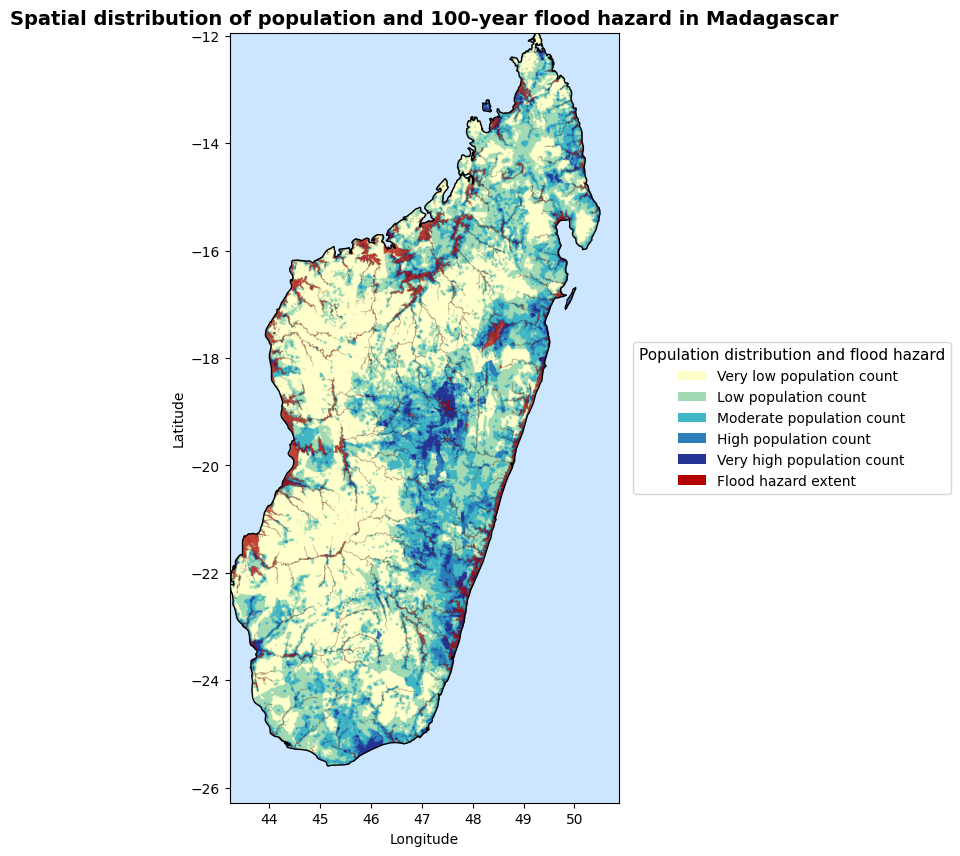

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_facecolor("#cce6ff")

ax.imshow(
    pop_plot,
    cmap=cmap_pop,
    norm=norm_pop,
    extent=plotting_extent(pop_plot, scaled_transform),
    origin="upper"
)

ax.imshow(
    np.where(flood_plot > 0, 1, np.nan),
    cmap=ListedColormap(["#b30000"]),
    alpha=0.75,
    extent=plotting_extent(flood_plot, scaled_transform),
    origin="upper"
)

madagascar.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

legend_elements = [Patch(facecolor=colors[i], label=labels[i]) for i in range(5)]
legend_elements.append(Patch(facecolor="#b30000", label="Flood hazard extent "))

ax.legend(
    handles=legend_elements,
    title="Population distribution and flood hazard",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

ax.set_title(
    "Spatial distribution of population and 100-year flood hazard in Madagascar",
    fontsize=14,
    weight="bold"
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig(
    f"{BASE}/outputs/madagascar_flood_map.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()